# Order Flow Risk of Ten US Stocks

### 1. Introduction
The Jupyter notebook shows the use of flowrisk package to calculate the VPIN values of ten us stocks. Five are large caps and five are small caps.

There are two ways to install flowrisk

    1. pip install flowrisk
    2. git clone http://github.com/hanxixuana/flowrisk
       cd flowrisk
       python setup.py install

More information can also be found at http://github.com/hanxixuana/flowrisk, such as the differences between this implementation and the original paper.

In [1]:
import flowrisk as fr
import matplotlib.pyplot as plt

%matplotlib inline

### 2. A Glance at the one-minute data of Goldman Sachs

The one-minute data has been included in the package. So we use the data loader to load it.

In [2]:
data_loader = fr.examples.usstocks.USLargeCapsDataLoader()
gs = data_loader.load_data('GS')
gs.head()

,date,5. volume,4. close,2. high,1. open,3. low
0,2018-11-12 09:31:00,0.0,221.900,221.90,221.650,221.650
1,2018-11-12 09:32:00,30241.0,220.640,221.49,221.490,220.640
2,2018-11-12 09:33:00,40978.0,219.805,220.49,220.365,219.730
3,2018-11-12 09:34:00,25867.0,219.710,220.05,220.050,219.465
4,2018-11-12 09:35:00,25656.0,219.450,219.93,219.930,219.260


In [3]:
gs.tail()

,date,5. volume,4. close,2. high,1. open,3. low
3084,2018-11-21 15:56:00,25498.0,192.4236,192.49,192.40,192.35
3085,2018-11-21 15:57:00,21360.0,192.5800,192.61,192.43,192.40
3086,2018-11-21 15:58:00,21667.0,192.6500,192.65,192.60,192.59
3087,2018-11-21 15:59:00,36793.0,192.8400,192.84,192.65,192.65
3088,2018-11-21 16:00:00,46335.0,192.5800,192.88,192.88,192.56


In [4]:
gs.describe()

,5. volume,4. close,2. high,1. open,3. low
count,3089.000000,3089.000000,3089.000000,3089.000000,3089.000000
mean,13197.447718,200.927304,201.012075,200.933746,200.846799
std,19008.809592,5.644017,5.670981,5.657022,5.627292
min,0.000000,190.500000,190.600000,190.500000,190.345000
25%,4812.000000,197.500000,197.570000,197.510000,197.450000
50%,8655.000000,201.740000,201.810000,201.750000,201.680000
75%,15938.000000,204.160000,204.246200,204.160000,204.072000
max,548542.000000,221.900000,221.900000,221.650000,221.650000



Let's have a whole picture of how it goes with the volumes.


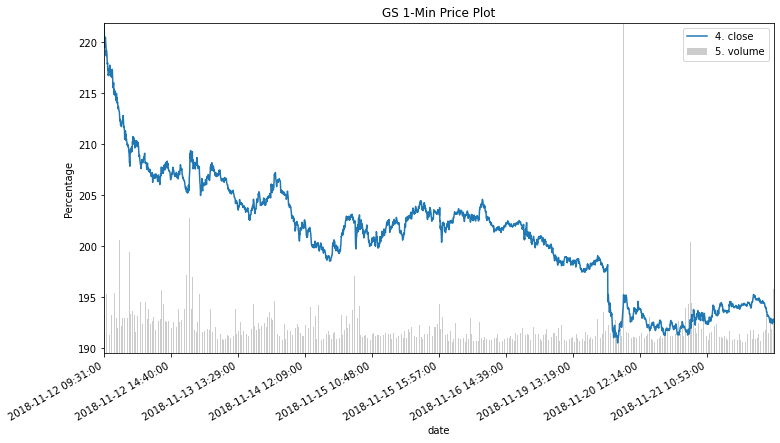

In [5]:
gs_volume = gs.loc[:, ['date', '5. volume']]
gs_volume.loc[:, '5. volume'] -= gs_volume.loc[:, '5. volume'].min()
gs_volume.loc[:, '5. volume'] /= gs_volume.loc[:, '5. volume'].max()
gs_volume.loc[:, '5. volume'] *= (gs['4. close'].max() - gs['4. close'].min()) * 2.0
gs_volume.loc[:, '5. volume'] += gs['4. close'].min()

ax = gs.plot(
    x='date',
    y='4. close',
    title='GS 1-Min Price Plot',
    xticks=gs.index
)

gs_volume.plot(
    x='date',
    y='5. volume',
    color='black',
    kind='bar',
    alpha=0.2,
    ax=ax,
    ylim=[gs['4. close'].min()-1.0, gs['4. close'].max()],
    figsize=[12, 6.75]
)

ax.set_ylabel("Percentage")
ax.locator_params(axis='x', nbins=10)
ax.figure.autofmt_xdate()

### 3. VPINs of GS and the associated confidence intervals

The package first of all has a recursive estimator of VPINs. This facilitates the online estimation of VPINs.

To facilitate the analysis here, we also have a bulk estimation estimator. In other words, it uses the recursive estimator to estimate the VPINs for a time series of prices and volumes.

Let's first have a configuration.

    1. N_BUCKET: the number of buckets for a single VPIN value
    2. BUCKET_MAX_VOLUME: the bucket size in the original paper
    3. VOL_DECAY: the decaying factor of historical prices when estimating the PnL volatility
    4. N_TIME_BAR_FOR_INITIALIZATION: the number of time bars used for initializing the PnL vol estimator

In [6]:
class Config(fr.BulkVPINConfig):
    
    TIME_BAR_TIME_STAMP_COL_NAME = 'date'
    TIME_BAR_PRICE_COL_NAME = '4. close'
    TIME_BAR_VOLUME_COL_NAME = '5. volume'
    
    N_TIME_BAR_FOR_INITIALIZATION = 50

config = Config()
config.summary()


Configurations:

BAND_ESTIMATOR                 RecursiveEWMABand
BUCKETS                        RecursiveBulkClassMABuckets
BUCKET_MAX_VOLUME              100000.0
N_BUCKET_OR_BUCKET_DECAY       20
N_TIME_BAR_FOR_INITIALIZATION  50
SYMBOL                         
TIME_BAR_PRICE_COL_NAME        4. close
TIME_BAR_TIME_STAMP_COL_NAME   date
TIME_BAR_VOLUME_COL_NAME       5. volume
VOL_DECAY                      0.8
VOL_ESTIMATOR                  RecursiveEWMAVol
VPIN_CONF_INTERVAL_RADIUS      2.0
VPIN_MEAN_EWMA_DECAY           0.9
VPIN_VOL_EWMA_DECAY            0.99




In [7]:
gs_vpin_estimator = fr.BulkVPIN(config)
gs_vpins = gs_vpin_estimator.estimate(gs)
gs_vpins.describe()

,vpin
count,3089.000000
mean,0.247546
std,0.082754
min,0.120355
25%,0.186457
50%,0.229185
75%,0.281144
max,0.518275


<AxesSubplot:title={'center':'VPIN from 2018-11-12 09:31:00 to 2018-11-21 16:00:00'}, xlabel='date', ylabel='Percentage'>

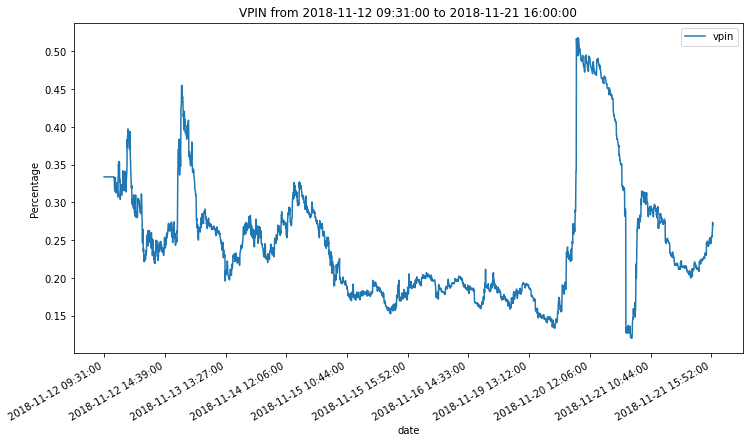

In [8]:
gs_vpin_estimator.plot()

To determine high VPIN periods, we construct a series of confidence intervals for VPIN.

We assume that the log innovation of VPIN follows a normal distribution. So

    1. we use an EWMA estimator to estimate the moving mean, and
    2. we use an EWMA estimator to estimate the moving volatility.

The related parameters are

    1. VPIN_CONF_INTERVAL_RADIUS: the amount of the volatility as the radius of the confidence interval (2.0 means 95% confidence interval)
    2. VPIN_MEAN_EWMA_DECAY: the decaying factor for the historical prices when calculating the moving mean
    3. VPIN_MEAN_EWMA_DECAY: the decaying factor for the historical prices when calculating the moving volatility


In [9]:
gs_conf_vpin_estimator = fr.BulkConfVPIN(config)
gs_vpins_and_conf_intervals = gs_conf_vpin_estimator.estimate(gs)
gs_vpins_and_conf_intervals.describe()

,vpin,vpin_lower_band,vpin_mean,vpin_upper_band
count,3089.000000,3089.000000,3089.000000,3089.000000
mean,0.247546,0.235428,0.247282,0.259879
std,0.082754,0.075682,0.081017,0.087201
min,0.120355,0.111515,0.128764,0.142674
25%,0.186457,0.178835,0.185497,0.192406
50%,0.229185,0.219479,0.230985,0.242564
75%,0.281144,0.263111,0.280575,0.297798
max,0.518275,0.455052,0.486575,0.529859


<AxesSubplot:title={'center':'VPIN from 2018-11-12 09:31:00 to 2018-11-21 16:00:00'}, xlabel='date', ylabel='Percentage'>

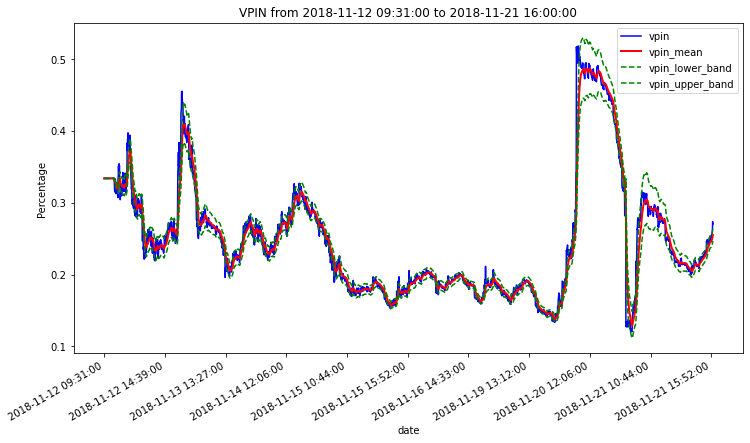

In [10]:
gs_conf_vpin_estimator.plot()

We also provide an integrated class for this example, given by fr.examples.USStocks.

It also gives a nice and whole picture of everything.


In [11]:
class Config(fr.BulkConfVPINConfig):

    N_TIME_BAR_FOR_INITIALIZATION = 50

config = Config()

usstock = fr.examples.USStocks(config)
gs_vpins_and_conf_intervals = usstock.estimate_vpin_and_conf_interval('GS')
gs_vpins_and_conf_intervals.describe()

,vpin,vpin_lower_band,vpin_mean,vpin_upper_band
count,3089.000000,3089.000000,3089.000000,3089.000000
mean,0.247546,0.235428,0.247282,0.259879
std,0.082754,0.075682,0.081017,0.087201
min,0.120355,0.111515,0.128764,0.142674
25%,0.186457,0.178835,0.185497,0.192406
50%,0.229185,0.219479,0.230985,0.242564
75%,0.281144,0.263111,0.280575,0.297798
max,0.518275,0.455052,0.486575,0.529859


<AxesSubplot:title={'center':'GS VPIN from 2018-11-12 09:31:00 to 2018-11-21 16:00:00'}, xlabel='date', ylabel='Percentage'>

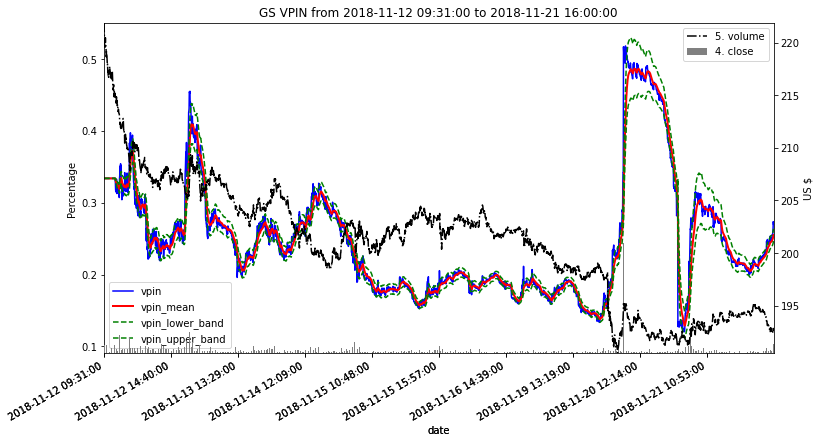

In [12]:
usstock.draw_price_vpins_and_conf_intervals(out_to_file=False)

### 4. VPINs of other US stocks With MA Buckets


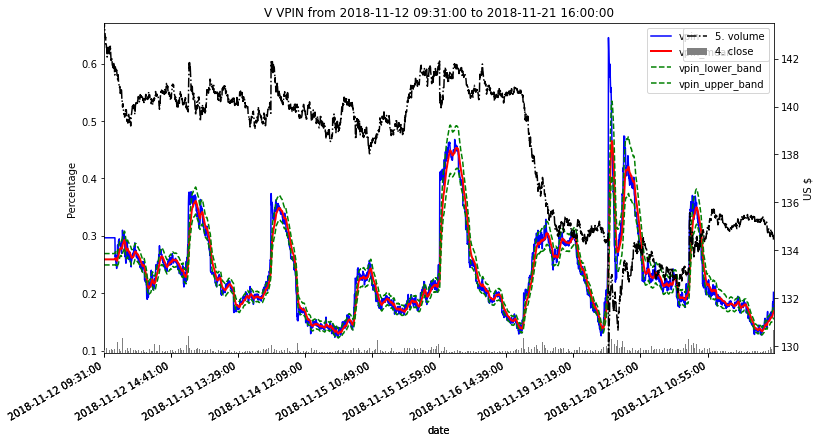

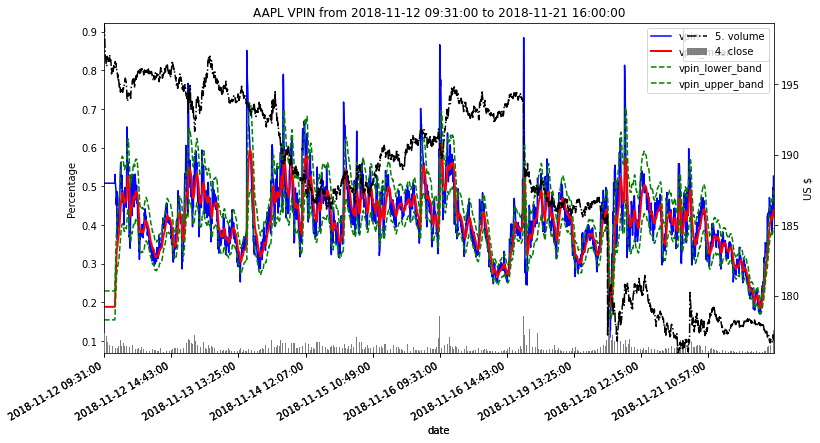

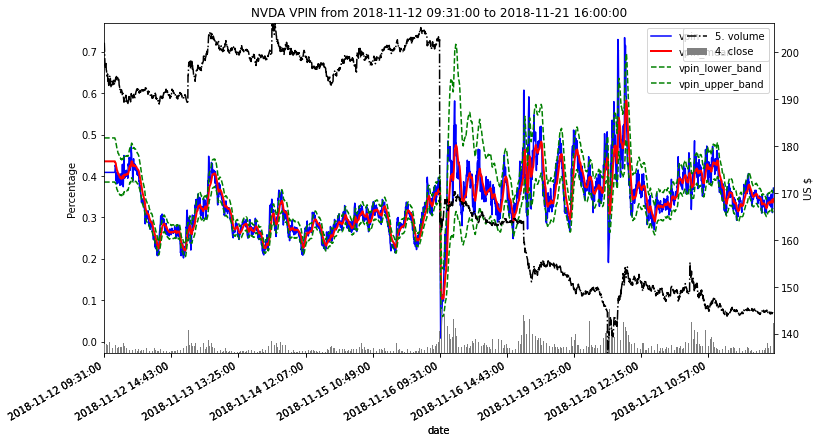

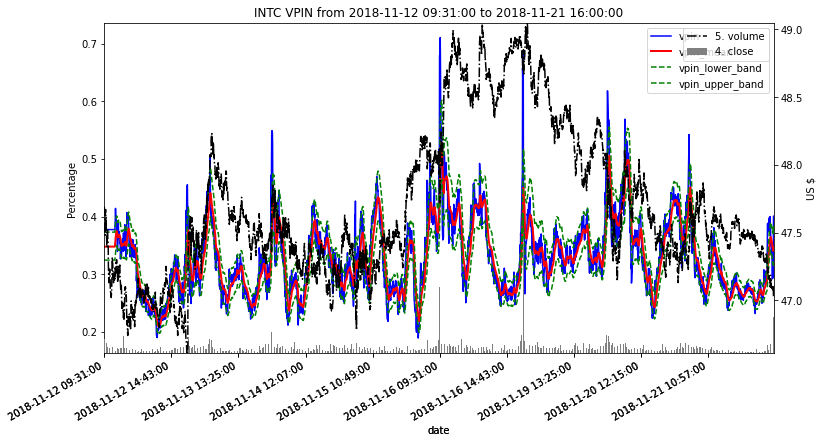

In [13]:
symbols = usstock.list_symbols('large')
symbols.remove('GS')
for symbol in symbols:
    result = usstock.estimate_vpin_and_conf_interval(symbol)
    usstock.draw_price_vpins_and_conf_intervals(out_to_file=False)

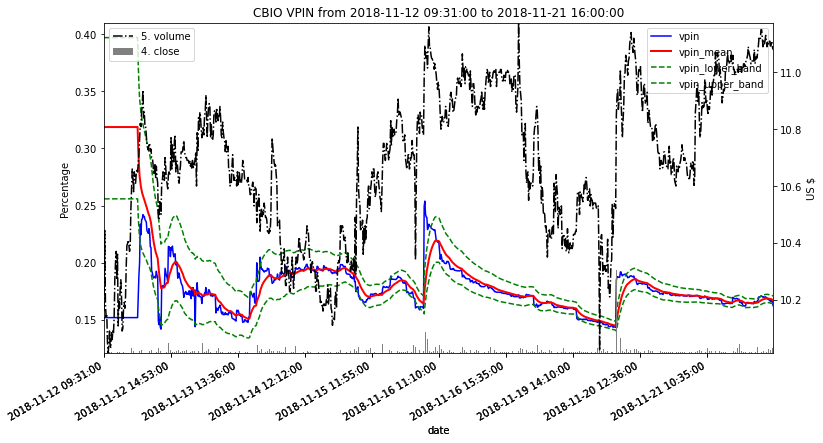

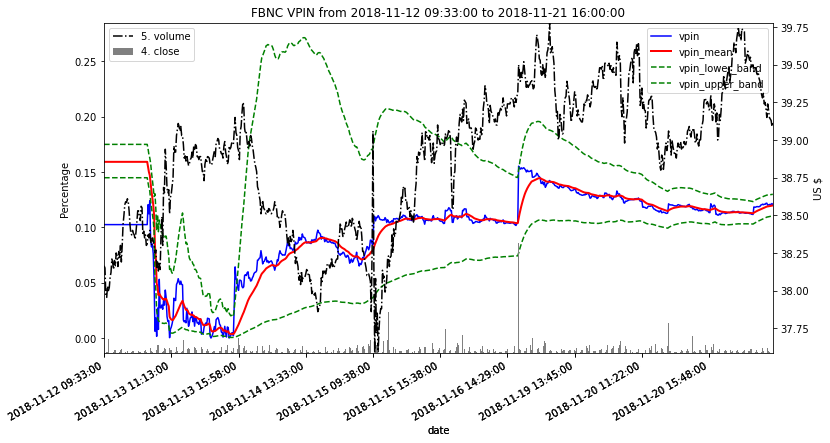

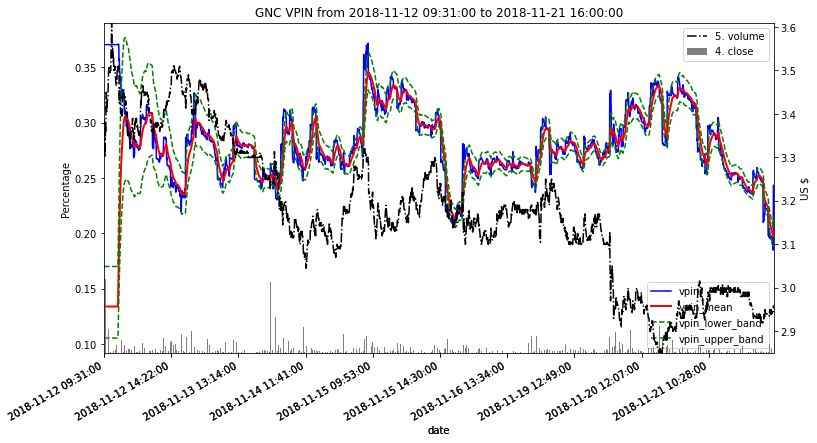

In [14]:
symbols = usstock.list_symbols('small')
for symbol in symbols[:3]:
    result = usstock.estimate_vpin_and_conf_interval(symbol)
    usstock.draw_price_vpins_and_conf_intervals(out_to_file=False)

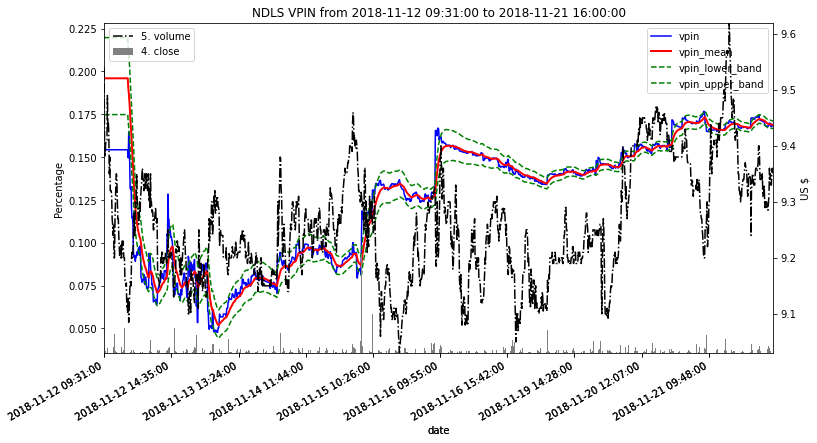

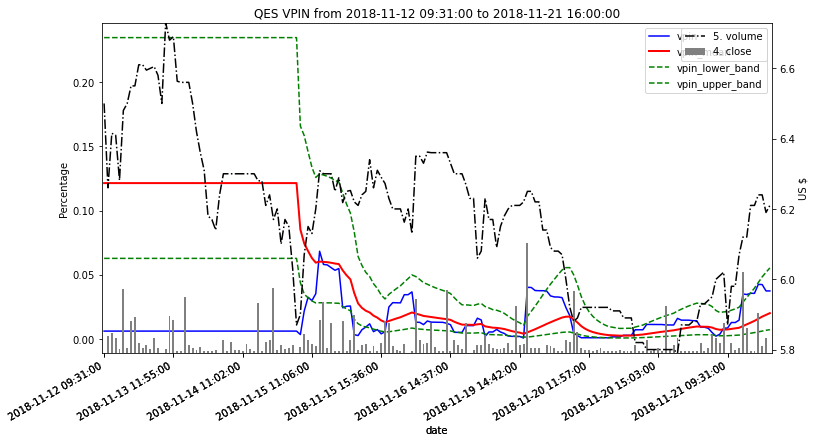

In [15]:
for symbol in symbols[3:]:
    result = usstock.estimate_vpin_and_conf_interval(symbol)
    usstock.draw_price_vpins_and_conf_intervals(out_to_file=False)

### 5. VPINs of other US stocks With EWMA Buckets



Configurations:

BAND_ESTIMATOR                 RecursiveEWMABand
BUCKETS                        RecursiveBulkClassEWMABuckets
BUCKET_MAX_VOLUME              10000.0
N_BUCKET_OR_BUCKET_DECAY       0.95
N_TIME_BAR_FOR_INITIALIZATION  50
SYMBOL                         
TIME_BAR_PRICE_COL_NAME        price
TIME_BAR_TIME_STAMP_COL_NAME   time
TIME_BAR_VOLUME_COL_NAME       volume
VOL_DECAY                      0.8
VOL_ESTIMATOR                  RecursiveEWMAVol
VPIN_CONF_INTERVAL_RADIUS      2.0
VPIN_MEAN_EWMA_DECAY           0.9
VPIN_VOL_EWMA_DECAY            0.99




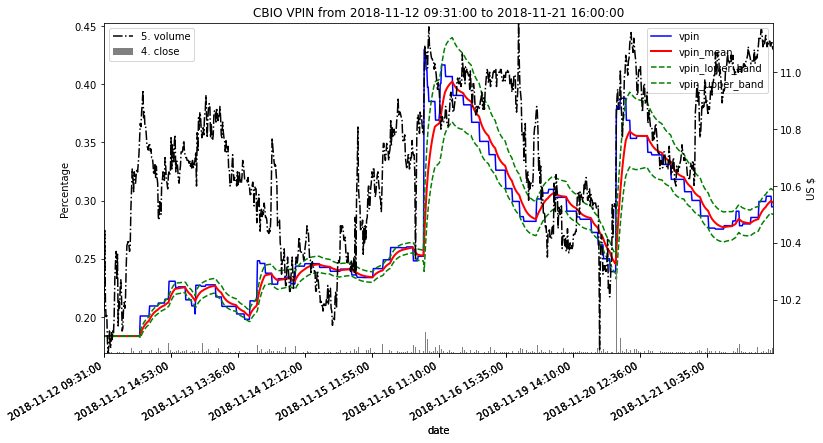

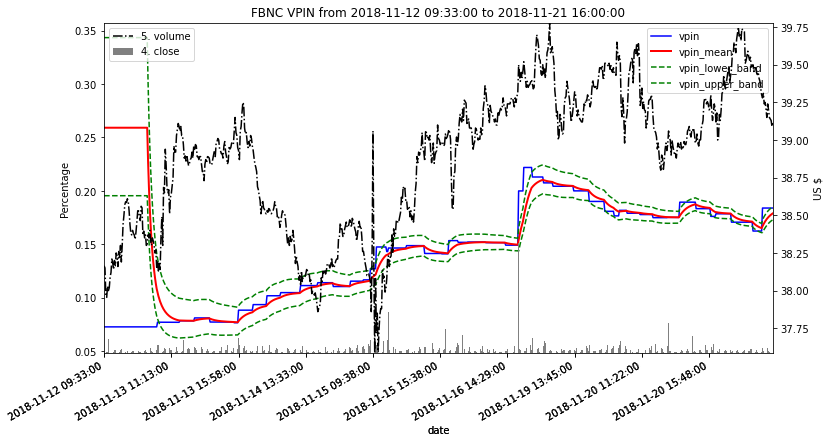

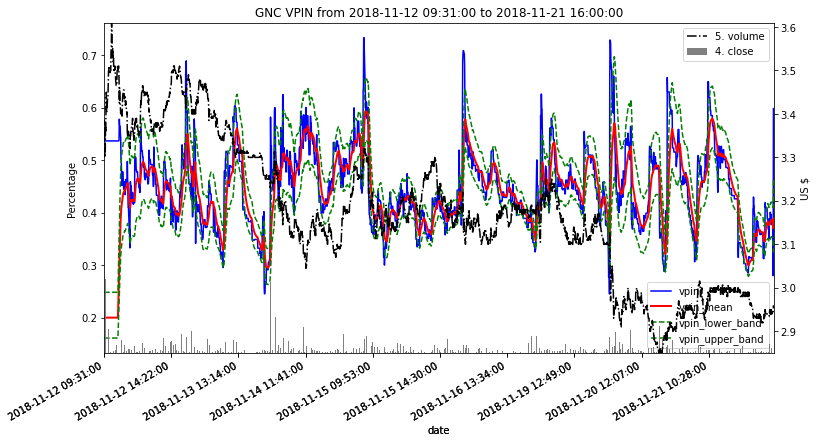

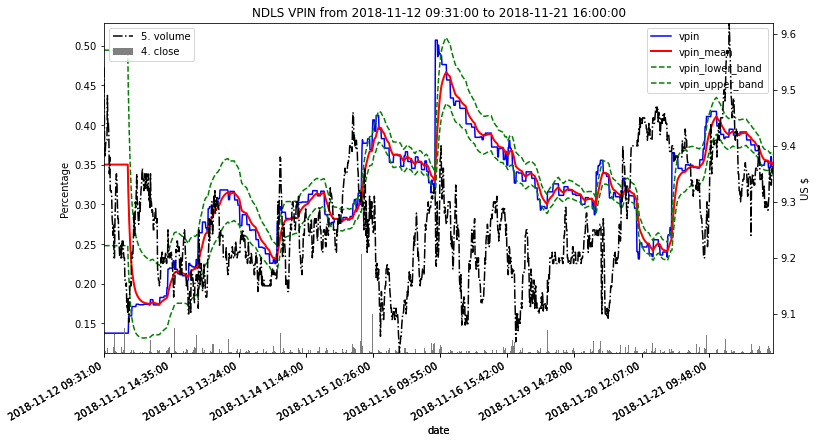

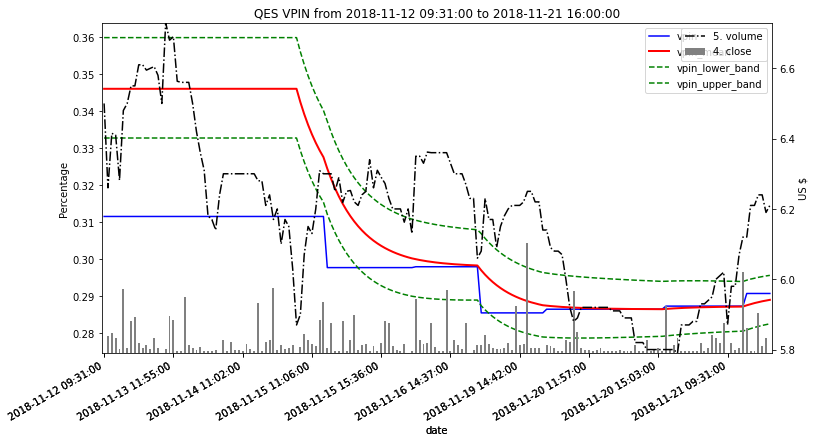

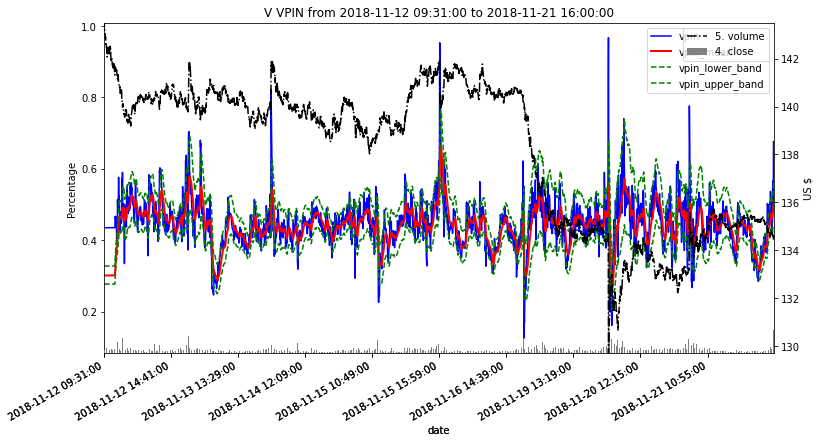

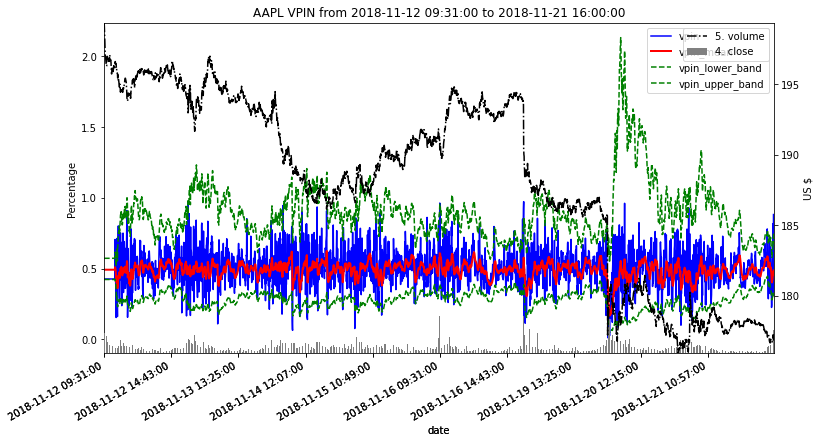

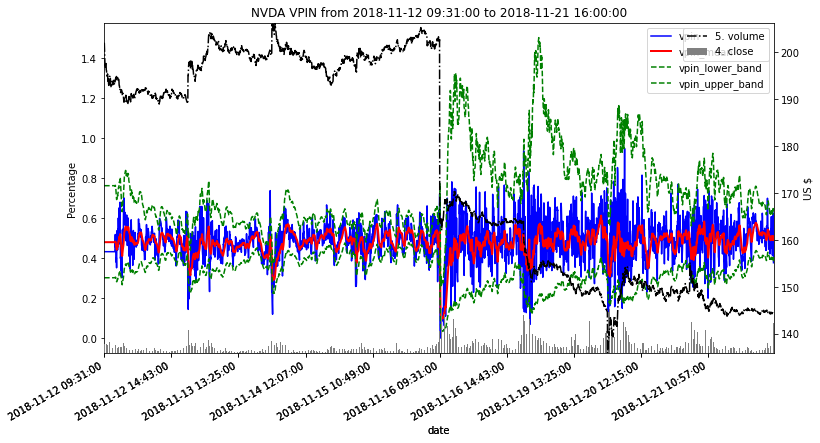

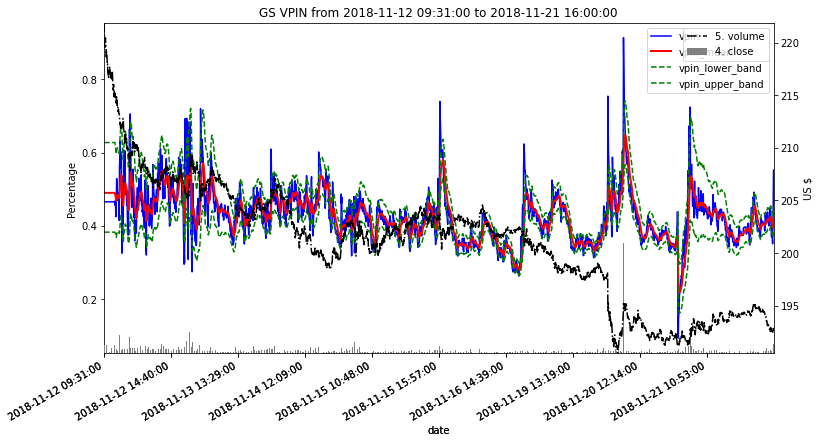

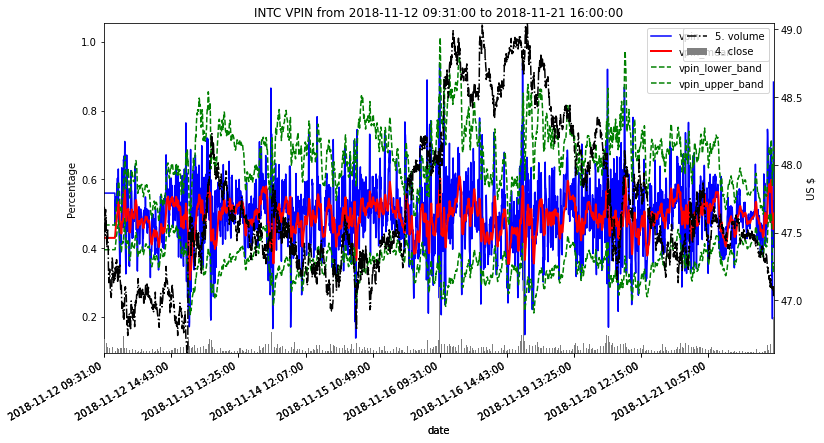

In [16]:
class Config(fr.BulkConfVPINConfig):

    N_TIME_BAR_FOR_INITIALIZATION = 50
    BUCKET_MAX_VOLUME = 10000.0
    N_BUCKET_OR_BUCKET_DECAY = 0.95
    BUCKETS = fr.bulk.RecursiveBulkClassEWMABuckets

config = Config()
config.summary()

example = fr.examples.USStocks(config)

symbols = example.list_symbols('small')
for symbol in symbols:
    result = example.estimate_vpin_and_conf_interval(symbol)
    example.draw_price_vpins_and_conf_intervals(out_to_file=False)

symbols = example.list_symbols('large')
for symbol in symbols:
    result = example.estimate_vpin_and_conf_interval(symbol)
    example.draw_price_vpins_and_conf_intervals(out_to_file=False)

End.